# GloFASv4 runs
*** 

**Author:** Chus Casado Rodríguez<br>
**Date:** 20-06-2024<br>

**Ideas:**<br>
* [x] Normalize the outflow by a maximum value (e.g. the non-damaging outflow)?
* [ ] The reservoir 193 has minimum, normal and non-damaging ouflows of 0, 0 and 0.1 m3/s!!

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
from pathlib import Path
path_root = Path(os.getcwd())

import glob
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import geopandas as gpd

os.chdir(path_root / '../../mekong_usecase/')
from notebooks.lisflood_read_plot import read_tss, xml_timeinfo
os.chdir(path_root)

from metrics import KGE, KGEmod
# from plots import storage_outflow

In [2]:
def filter_ts(df: pd.DataFrame, replace: float = 1e31) -> pd.DataFrame:
    """Replace the specific value by NaN and remove columns with all NaN.
    
    Parameters:
    -----------
    df:        pd.DataFrame
        input time series
    replace:   float
        value to be replaced by NaN
        
    Output:
    -------
    df:    pd.DataFrame
        the input time series in which the specific value has been replaced by NaN, and empty columns have been removed
    """
    
    df.replace(replace, np.nan, inplace=True)
    df.dropna(axis=1, how='all', inplace=True)
    df.columns = [int(col) for col in df.columns]
    df.sort_index(axis=1, inplace=True)
    
    return df

## Configuration

In [3]:
path_glofas = Path('Z:/nahaUsers/casadje/GloFASv4/')
settings_file = 'settings_lisflood_wusewregion_FULLinit_GloFASnext-PreRunX.xml'

path_datasets = Path('Z:/nahaUsers/casadje/datasets/')

start, end = datetime(1982, 1, 2), datetime(2019, 12, 31)

In [116]:
catchment = 'grande'

## Data

### Calibration points

In [117]:
stations = gpd.read_file(f'../GIS/GloFAS_stations_{catchment}.shp')
stations.set_index('ObsID', drop=True, inplace=True)

print(f'{stations.shape[0]} stations in the {catchment} basin')

9 stations in the grande basin


In [118]:
with open(path_glofas / 'catchments' / f'catchments_{catchment}.txt', 'w') as file:
    for item in stations.index:
        file.write(item + os.linesep)

### Reservoirs

In [119]:
# import GIS shapefile with the reservoirs to be analysed
res_glofas = gpd.read_file(f'../data/reservoirs/GloFAS/GloFAS_reservoirs.shp')
res_glofas.set_index('ResID', drop=True, inplace=True)

print(f'{res_glofas.shape[0]} reservoirs in GloFAS')

685 reservoirs in GloFAS


In [120]:
# import GIS shapefile with the reservoirs to be analysed
res_glofas_resops = gpd.read_file(f'../GIS/reservoirs_GloFAS_ResOpsUS.shp')
res_glofas_resops.set_index('ResID', drop=True, inplace=True)

print(f'{res_glofas_resops.shape[0]} reservoirs in GloFAS and ResOpsUS.')
print(f'{(res_glofas_resops.CATCHMENT == catchment).sum()} of them in the {catchment} basin')

113 reservoirs in GloFAS and ResOpsUS.
4 of them in the grande basin


***

In [123]:
path_glofas = Path('Z:/nahaUsers/casadje/GloFASv4/')

catchment_reservoirs = {}
rm_catchments = []
for id in stations.index:
    
    try:
        # load reservoir map from the LISFLOOD catchment model
        path = path_glofas / 'catchments' / id
        res = xr.open_mfdataset(f'{path}/maps/*_res_GLobal_03min.nc')['res'].compute()

        # find reservoirs in the catchment
        res = res.data.flatten()
        res = np.unique(res[~np.isnan(res)]).astype(int)

        if len(res) > 0:
            catchment_reservoirs[id] = res
        else:
            rm_catchments.append(id)
            
    except:
        continue

ObsIDs = list(catchment_reservoirs)
ResIDs = np.unique([x for id, ls in catchment_reservoirs.items() for x in ls])
print(f'{len(ObsIDs)} catchments contain a total of {len(ResIDs)} reservoirs')
n_res = len(res_glofas_resops[res_glofas_resops.CATCHMENT == catchment].index.intersection(ResIDs))
print(f'{n_res} match those in the rerservoir shapefile')

5 catchments contain a total of 10 reservoirs
4 match those in the rerservoir shapefile


In [124]:
rm_catchments

['838', '842', '869', '921']

In [126]:
with open(path_glofas / 'catchments' / f'catchments_{catchment}_w_res.txt', 'w') as file:
    for item in ObsIDs:
        file.write(item + '\n')

In [127]:
catchment_reservoirs

{'805': array([18]),
 '822': array([18]),
 '871': array([ 51, 382]),
 '911': array([387, 468]),
 '923': array([ 32,  51,  81,  84, 229, 387, 468, 483])}

***

### GloFAS

#### LISFLOOD runs

In [151]:
catchments['pacific']

{671: [], 682: [417], 758: [103, 481, 507], 780: [201, 250, 374, 375]}

In [152]:
path_glofas = Path('E:/casadje/Documents/GloFASv4')

# import time series resulting from the reservoir simulation
lf_ts = {var: pd.DataFrame(dtype=float) for var in ['resfill', 'qresin', 'qresout']}
path0 = path_glofas / 'catchments'
catchments = {x: {} for x in os.listdir(path0) if os.path.isdir(os.path.join(path0 / f'{x}'))}

for catchment in tqdm(catchments):
    path1 = path0 / catchment
    subcatchments = {int(x): [] for x in os.listdir(path1) if os.path.isdir(os.path.join(path1 / f'{x}'))}
    for id in tqdm(subcatchments):
        path2 = path1 / f'{id}'
        for var in lf_ts:
            try:
                df = read_tss(tss=path2 / 'out' / f'{var}.tss',
                              xml=path2 / 'settings' / settings_file,
                              squeeze=False)
                # remove reservoirs without values
                df = filter_ts(df)
                # # remove resevoirs not in ResOpsUS
                # df = df.loc[:,df.columns.isin(reservoirs.index)]
                # save extraction
                subcatchments[id] = df.columns.tolist()
                lf_ts[var] = pd.concat((lf_ts[var], df.loc[start:end]), axis=1)
            except:
                print(f'Catchment {path2} does not have the file {var}.tss')
    catchments[catchment] = subcatchments
lf_ts = {var: df.sort_index(axis=1) for var, df in lf_ts.items()}

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [153]:
no_res_sim = len(lf_ts['resfill'].columns.intersection(res_glofas_resops.index))
print(f'The time series contain {no_res_sim} out of {res_glofas_resops.shape[0]} reservoirs')

The time series contain 107 out of 113 reservoirs


In [154]:
res_glofas_resops.index.difference(lf_ts['resfill'].columns)

Int64Index([68, 179, 185, 197, 296, 323], dtype='int64')

In [155]:
# reorganize data with a DataFrame per reservoir
glofas = {}
for id in tqdm(lf_ts['resfill'].columns):
    df = pd.DataFrame({var: lf_ts[var][id] for var in ['resfill', 'qresin', 'qresout']})
    df.index.name = 'date'
    df.rename(columns={'resfill': 'storage', 'qresin': 'inflow', 'qresout': 'outflow'}, inplace=True)
    # export as CSV
    file = f'../data/reservoirs/GloFAS/long_run/{id:03}.csv'
    if not os.path.exists(file): 
        print(f'writing file {file}...')
        df.to_csv(file)
    # transform flows by the non-damaging outflow
    df[['inflow', 'outflow']] /= reservoirs.loc[id, 'ndq']
    # save in the dictionary
    glofas[id] = df

  0%|          | 0/143 [00:00<?, ?it/s]

writing file ../data/reservoirs/GloFAS/long_run/084.csv...
writing file ../data/reservoirs/GloFAS/long_run/483.csv...


#### Long run

In [159]:
var = 'rsfil'

# load simulated reservoir storage
path = Path(f'../data/reservoirs/GloFAS/long_run/{var}')
df = xr.open_mfdataset(f'{path}/*.nc', combine='nested', concat_dim='ResID')[var].to_pandas().transpose()
df = df.loc[start:end]

# make sure the DataFrame contains all days between 'start' and 'end'
FFsim = pd.DataFrame(index=pd.date_range(start, end, freq='D'), columns=df.columns, dtype=float)
FFsim.index.name = 'date'
FFsim.columns.name = 'ResID'
FFsim.loc[df.index, :] = df
del df

FFsim.shape

(13878, 121)

### ResOpsUS
#### Time series

In [161]:
path_ResOps = Path(path_datasets / 'reservoirs' / 'ResOpsUS')

resops = {}
for glofas_id in tqdm(reservoirs.index):
    # load timeseries
    grand_id = reservoirs.loc[glofas_id, 'GRAND_ID']
    series_id = pd.read_csv(path_ResOps / 'time_series_all' / f'ResOpsUS_{grand_id:.0f}.csv', parse_dates=True, index_col='date')
    # remove empty time series
    series_id = series_id.loc[start:end]#.dropna(axis=1, how='all')
    # remove duplicated index
    series_id = series_id[~series_id.index.duplicated(keep='first')]
    # convert storage in fraction filled
    series_id.storage /= reservoirs.loc[glofas_id, 'CAP']
    # convert flows in fraction of non-damaging flow
    series_id[['inflow', 'outflow']] /= reservoirs.loc[glofas_id, 'ndq']
    # save in dictionary
    resops[glofas_id] = series_id

  0%|          | 0/685 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\nahaUsers\\casadje\\datasets\\reservoirs\\ResOpsUS\\time_series_all\\ResOpsUS_3662.csv'

## Analysis

### Reservoir storage: GloFAS long run vs LISFLOOD runs

KeyError: 'nlim_adj'

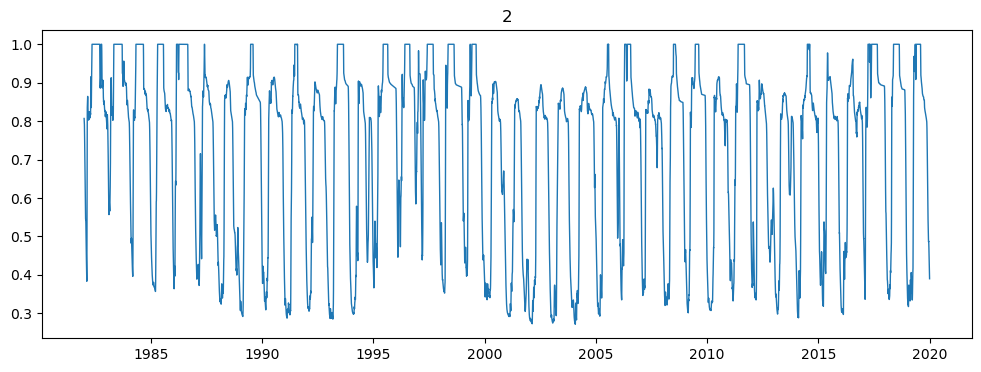

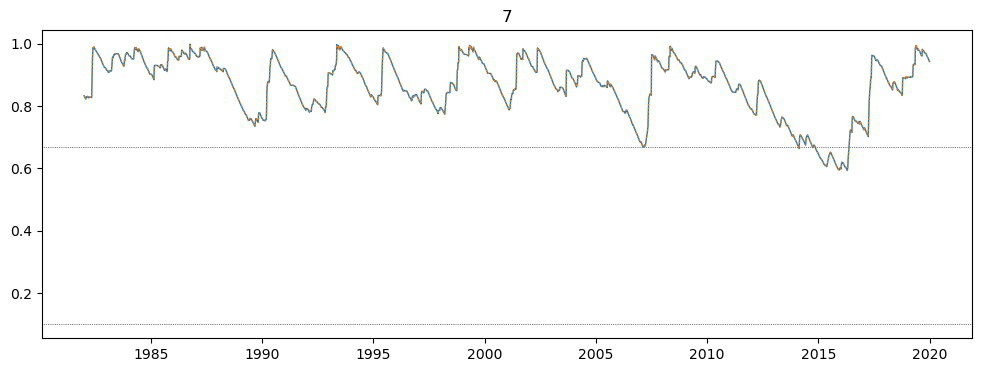

In [162]:
for id, df in glofas.items():

    plt.figure(figsize=(12, 4))
    plt.title(id)
    plt.plot(df.index, df.storage, lw=1, label='LISFLOOD')
    try:
        plt.plot(FFsim.index, FFsim[id], ':', lw=1, label='long run')
    except:
        continue
    for col in ['clim', 'nlim', 'nlim_adj', 'flim']:
        plt.axhline(reservoirs.loc[id, col], c='k', ls=':', lw=.5, zorder=0)
    plt.legend(frameon=False, loc=4)
    plt.xlim(start, end)
    plt.ylim(-.02, 1.02)

There is only one reservoir in which the reservoir fraction filled simulated in the GloFAS long run and that simulated with the LISFLOOD individual catchments do NOT match. It is the reservoir 54 Gavins Point Dam.

In [ ]:
for id, df in glofas.items():

    plt.figure(figsize=(12, 4))
    plt.title(id)
    plt.plot(df.index, df.inflow, lw=1, label='inflow')
    plt.plot(df.index, df.outflow, lw=1, label='outflow')
    
    for col in ['minq', 'normq', 'normq_adj', 'ndq']:
        plt.axhline(reservoirs.loc[id, col], c='k', ls=':', lw=.5, zorder=0)
        
    plt.xlim(start, end)
    plt.ylim(-1, None)
    # plt.yscale('log')
    plt.legend(frameon=False, loc=1)
    # break

* The performance of the outflow is notable higher than that of the reservoir storage. That makes sense, since the target of the calibration is only streamflow.
* The scatter plots of observed storage vs outflow show considerable dispersion, what proves that the outflow is not defined simply by the reservoir storage at that time.
* It is surprising that we the reservoir routing allows the outflow to exceed the non-damaging outflow by up to 17 times. <font color=red> Where was the non-damaging outflow taken from?</font>